# IMPORT

In [79]:
%%capture
!pip install --upgrade scikit-learn

In [80]:
import gc
gc.enable()
import warnings
warnings.filterwarnings(category=FutureWarning, action='ignore')
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, chi2, f_classif
from sklearn.metrics import (
    roc_auc_score,
    matthews_corrcoef,
    classification_report
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, TargetEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (RandomForestClassifier)
from xgboost import XGBClassifier
SEED = 2024

In [81]:
url = "https://drive.google.com/uc?id=1_oNqybyeIxd3lnZwD_esMTNSmqgB_hsI"
data = pd.read_csv(url)
data.head()

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,company,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.0,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,NaN,NaN,0,Transient,0.0,0,0,Check-Out,2015-07-01
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,NaN,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.0,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304.0,NaN,0,Transient,75.0,0,0,Check-Out,2015-07-02
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.0,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240.0,NaN,0,Transient,98.0,0,1,Check-Out,2015-07-03


# EDA

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [83]:
leakage_cols = [
    'reservation_status',
    'reservation_status_date',
    'booking_changes',
    'deposit_type'
]

data = data.drop(leakage_cols, axis=1)

TARGET = 'is_canceled'
features = list(data.columns)
features.remove(TARGET)

**Class ratio**

In [84]:
data[TARGET].value_counts(normalize=True)

class_ratio = data[TARGET].value_counts()[0] / data[TARGET].value_counts()[1]
class_ratio = round(class_ratio, 2)
class_ratio

1.7

**Data summary**

In [85]:
cat_features = list(data.select_dtypes('object').columns)
cat_features.extend(['arrival_date_year', 'is_repeated_guest', 'agent', 'company'])

num_features = [f for f in features if f not in cat_features]

data[num_features].describe()

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,previous_cancellations,previous_bookings_not_canceled,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119386.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,104.011416,27.165173,15.798241,0.927599,2.500302,1.856403,0.103890,0.007949,0.087118,0.137097,2.321149,101.831122,0.062518,0.571363
std,106.863097,13.605138,8.780829,0.998613,1.908286,0.579261,0.398561,0.097436,0.844336,1.497437,17.594721,50.535790,0.245291,0.792798
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000
25%,18.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000
50%,69.000000,28.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000
75%,160.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000
max,737.000000,53.000000,31.000000,19.000000,50.000000,55.000000,10.000000,10.000000,26.000000,72.000000,391.000000,5400.000000,8.000000,5.000000


# FEATURE





In [86]:
def cat_dist(f):
    print('Category proportions:\n', data[f].value_counts(normalize=True, dropna=False))
    print('\nTarget splits for each category:\n', data.groupby(f, dropna=False)[TARGET].value_counts(normalize=True))

def num_dist(f, clip=None):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))
    plt.suptitle(f'{f}')
    plt.minorticks_on()
    ax[0].set_title(f"Distribution split by target")
    sns.kdeplot(x=f, data=data, hue=TARGET, clip=clip, cut=0, ax=ax[0])
    ax[1].set_title(f"Distribution for positive class")
    sns.kdeplot(x=f, data=data.loc[data[TARGET]==1], clip=clip, cut=0, ax=ax[1])
    plt.tight_layout()
    plt.show()

**hotel**

In [87]:
cat_dist('hotel')

Category proportions:
 hotel
City Hotel      0.664461
Resort Hotel    0.335539
Name: proportion, dtype: float64

Target splits for each category:
 hotel         is_canceled
City Hotel    0              0.582730
              1              0.417270
Resort Hotel  0              0.722366
              1              0.277634
Name: proportion, dtype: float64


**arrival_date_month**

In [88]:
cat_dist('arrival_date_month')

Category proportions:
 arrival_date_month
August       0.116233
July         0.106047
May          0.098760
October      0.093475
April        0.092880
June         0.091624
September    0.088014
March        0.082034
February     0.067577
November     0.056906
December     0.056789
January      0.049661
Name: proportion, dtype: float64

Target splits for each category:
 arrival_date_month  is_canceled
April               0              0.592028
                    1              0.407972
August              0              0.622469
                    1              0.377531
December            0              0.650295
                    1              0.349705
February            0              0.665840
                    1              0.334160
January             0              0.695227
                    1              0.304773
July                0              0.625464
                    1              0.374536
June                0              0.585428
                    1 

In [89]:
winter = ('September', 'October', 'November', 'December', 'January', 'February', 'March')
data['arrival_month_bin'] = data.arrival_date_month.apply(lambda x: x in winter).astype('int')

cat_dist('arrival_month_bin')

Category proportions:
 arrival_month_bin
0    0.505545
1    0.494455
Name: proportion, dtype: float64

Target splits for each category:
 arrival_month_bin  is_canceled
0                  0              0.607055
                   1              0.392945
1                  0              0.652618
                   1              0.347382
Name: proportion, dtype: float64


**arrival_date_year**

In [90]:
cat_dist('arrival_date_year')

Category proportions:
 arrival_date_year
2016    0.474973
2017    0.340791
2015    0.184237
Name: proportion, dtype: float64

Target splits for each category:
 arrival_date_year  is_canceled
2015               0              0.629842
                   1              0.370158
2016               0              0.641367
                   1              0.358633
2017               0              0.613021
                   1              0.386979
Name: proportion, dtype: float64


In [91]:
data['arrival_date_year'] = data.arrival_date_year - 2015

In [92]:
cat_features.remove('arrival_date_year')
num_features.append('arrival_date_year')

**meal**

In [93]:
cat_dist('meal')

Category proportions:
 meal
BB           0.773180
HB           0.121141
SC           0.089203
Undefined    0.009791
FB           0.006684
Name: proportion, dtype: float64

Target splits for each category:
 meal       is_canceled
BB         0              0.626151
           1              0.373849
FB         1              0.598997
           0              0.401003
HB         0              0.655397
           1              0.344603
SC         0              0.627606
           1              0.372394
Undefined  0              0.755346
           1              0.244654
Name: proportion, dtype: float64


In [94]:
data['meal_bin'] = (data.meal == 'SC').astype('int')

cat_dist('meal_bin')

Category proportions:
 meal_bin
0    0.910797
1    0.089203
Name: proportion, dtype: float64

Target splits for each category:
 meal_bin  is_canceled
0         0              0.629777
          1              0.370223
1         0              0.627606
          1              0.372394
Name: proportion, dtype: float64


**country**

In [95]:
data['country'].value_counts(normalize=True, dropna=False)[:10]

,proportion
country,
PRT,0.406986
GBR,0.101591
FRA,0.087235
ESP,0.071765
DEU,0.061035
ITA,0.031544
IRL,0.028269
BEL,0.019616
BRA,0.018628


Sebagian besar negara teratas adalah negara-negara Eropa.

In [96]:
data.country.nunique()

177

In [97]:
data.groupby('country', dropna=False)[TARGET].value_counts().sort_values(ascending=False)[:20]

country  is_canceled
PRT      1              27519
         0              21071
GBR      0               9676
FRA      0               8481
ESP      0               6391
DEU      0               6069
IRL      0               2543
GBR      1               2453
ITA      0               2433
ESP      1               2177
FRA      1               1934
BEL      0               1868
NLD      0               1717
USA      0               1596
BRA      0               1394
ITA      1               1333
CHE      0               1302
DEU      1               1218
AUT      0               1033
CN       0               1025
Name: count, dtype: int64

In [98]:
data.loc[data.country.isna()][TARGET].value_counts(normalize=True)

,proportion
is_canceled,
0,0.862705
1,0.137295


In [99]:
def country_to_binary(country):
    if country in ('PRT', 'ITA', 'ESP'):
        return 1
    else:
        return 0

data['country_bin'] = data['country'].apply(country_to_binary)
cat_dist('country_bin')

Category proportions:
 country_bin
1    0.510294
0    0.489706
Name: proportion, dtype: float64

Target splits for each category:
 country_bin  is_canceled
0            0              0.774313
             1              0.225687
1            1              0.509307
             0              0.490693
Name: proportion, dtype: float64


**market_segment**

In [100]:
cat_dist('market_segment')

Category proportions:
 market_segment
Online TA        0.473046
Offline TA/TO    0.202856
Groups           0.165935
Direct           0.105587
Corporate        0.044350
Complementary    0.006223
Aviation         0.001985
Undefined        0.000017
Name: proportion, dtype: float64

Target splits for each category:
 market_segment  is_canceled
Aviation        0              0.780591
                1              0.219409
Complementary   0              0.869448
                1              0.130552
Corporate       0              0.812653
                1              0.187347
Direct          0              0.846581
                1              0.153419
Groups          1              0.610620
                0              0.389380
Offline TA/TO   0              0.656840
                1              0.343160
Online TA       0              0.632789
                1              0.367211
Undefined       1              1.000000
Name: proportion, dtype: float64


In [101]:
data['market_segment_bin'] = (data['market_segment'] == 'Online TA').astype('int')
cat_dist('market_segment_bin')

Category proportions:
 market_segment_bin
0    0.526954
1    0.473046
Name: proportion, dtype: float64

Target splits for each category:
 market_segment_bin  is_canceled
0                   0              0.626707
                    1              0.373293
1                   0              0.632789
                    1              0.367211
Name: proportion, dtype: float64


**distribution_channel**

In [102]:
cat_dist('distribution_channel')

Category proportions:
 distribution_channel
TA/TO        0.819750
Direct       0.122665
Corporate    0.055926
GDS          0.001617
Undefined    0.000042
Name: proportion, dtype: float64

Target splits for each category:
 distribution_channel  is_canceled
Corporate             0              0.779242
                      1              0.220758
Direct                0              0.825401
                      1              0.174599
GDS                   0              0.808290
                      1              0.191710
TA/TO                 0              0.589741
                      1              0.410259
Undefined             1              0.800000
                      0              0.200000
Name: proportion, dtype: float64


In [103]:
data['distribution_channel_bin'] = (data['distribution_channel'] == 'TA/TO').astype('int')

cat_dist('distribution_channel_bin')

Category proportions:
 distribution_channel_bin
1    0.81975
0    0.18025
Name: proportion, dtype: float64

Target splits for each category:
 distribution_channel_bin  is_canceled
0                         0              0.810781
                          1              0.189219
1                         0              0.589741
                          1              0.410259
Name: proportion, dtype: float64


**reserved_room_type**

In [104]:
cat_dist('reserved_room_type')

Category proportions:
 reserved_room_type
A    0.720278
D    0.160826
E    0.054737
F    0.024265
G    0.017539
B    0.009364
C    0.007806
H    0.005034
P    0.000101
L    0.000050
Name: proportion, dtype: float64

Target splits for each category:
 reserved_room_type  is_canceled
A                   0              0.608926
                    1              0.391074
B                   0              0.670841
                    1              0.329159
C                   0              0.669528
                    1              0.330472
D                   0              0.682204
                    1              0.317796
E                   0              0.707116
                    1              0.292884
F                   0              0.696237
                    1              0.303763
G                   0              0.635626
                    1              0.364374
H                   0              0.592346
                    1              0.407654
L             

**assigned_room_type**

In [105]:
cat_dist('assigned_room_type')

Category proportions:
 assigned_room_type
A    0.620261
D    0.212095
E    0.065382
F    0.031418
G    0.021384
C    0.019893
B    0.018117
H    0.005964
I    0.003040
K    0.002337
P    0.000101
L    0.000008
Name: proportion, dtype: float64

Target splits for each category:
 assigned_room_type  is_canceled
A                   0              0.555075
                    1              0.444925
B                   0              0.763292
                    1              0.236708
C                   0              0.812211
                    1              0.187789
D                   0              0.748756
                    1              0.251244
E                   0              0.747886
                    1              0.252114
F                   0              0.752866
                    1              0.247134
G                   0              0.694477
                    1              0.305523
H                   0              0.647472
                    1         

In [106]:
data['same_room_assigned'] = (data['reserved_room_type'] == data['assigned_room_type']).astype('int')

cat_dist('same_room_assigned')

Category proportions:
 same_room_assigned
1    0.875057
0    0.124943
Name: proportion, dtype: float64

Target splits for each category:
 same_room_assigned  is_canceled
0                   0              0.946236
                    1              0.053764
1                   0              0.584371
                    1              0.415629
Name: proportion, dtype: float64


**customer_type**

In [107]:
cat_dist('customer_type')

Category proportions:
 customer_type
Transient          0.750591
Transient-Party    0.210436
Contract           0.034140
Group              0.004833
Name: proportion, dtype: float64

Target splits for each category:
 customer_type    is_canceled
Contract         0              0.690383
                 1              0.309617
Group            0              0.897747
                 1              0.102253
Transient        0              0.592537
                 1              0.407463
Transient-Party  0              0.745701
                 1              0.254299
Name: proportion, dtype: float64


In [108]:
data['customer_type_bin'] = (data.customer_type == 'Transient').astype('int')

cat_dist('customer_type_bin')

Category proportions:
 customer_type_bin
1    0.750591
0    0.249409
Name: proportion, dtype: float64

Target splits for each category:
 customer_type_bin  is_canceled
0                  0              0.741075
                   1              0.258925
1                  0              0.592537
                   1              0.407463
Name: proportion, dtype: float64


**is_repeated_guest**

In [109]:
cat_dist('is_repeated_guest')

Category proportions:
 is_repeated_guest
0    0.968088
1    0.031912
Name: proportion, dtype: float64

Target splits for each category:
 is_repeated_guest  is_canceled
0                  0              0.622149
                   1              0.377851
1                  0              0.855118
                   1              0.144882
Name: proportion, dtype: float64


**agent**

In [110]:
data.agent.nunique()
data.agent.unique()[:10]
data.agent.value_counts(dropna=False).head()
data.groupby('agent')[TARGET].value_counts(normalize=True, dropna=False)[:10]

agent  is_canceled
1.0    1              0.734251
       0              0.265749
2.0    0              0.790123
       1              0.209877
3.0    1              0.577096
       0              0.422904
4.0    1              0.659574
       0              0.340426
5.0    0              0.548485
       1              0.451515
Name: proportion, dtype: float64

**company**

In [111]:
data.company.nunique()
data.company.unique()[:10]
data.company.value_counts(dropna=False, normalize=True).head()

,proportion
company,
NaN,0.943069
40.0,0.007764
223.0,0.006567
67.0,0.002236
45.0,0.002094


**lead_time**

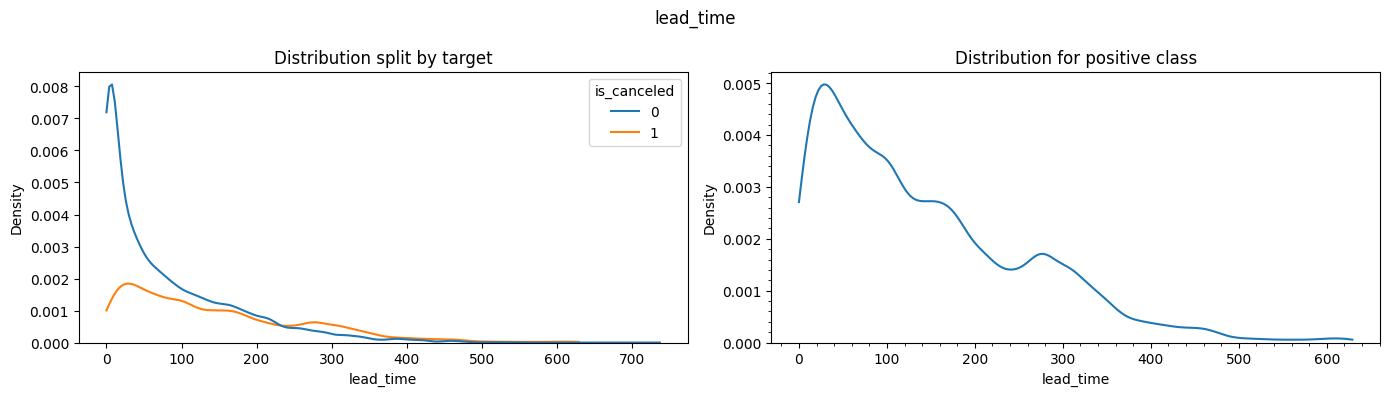

,proportion
is_canceled,
0,0.93223
1,0.06777


In [112]:
num_dist('lead_time')
data.loc[data.lead_time == 0][TARGET].value_counts(normalize=True)

**arrival_data_week_number**

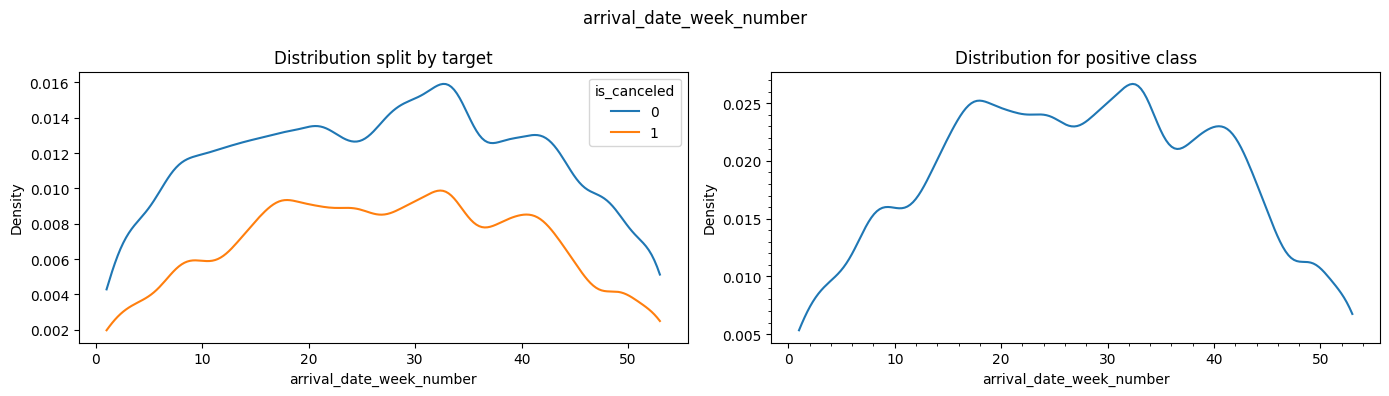

In [113]:
num_dist('arrival_date_week_number')

**arrival_date_day_of_month**

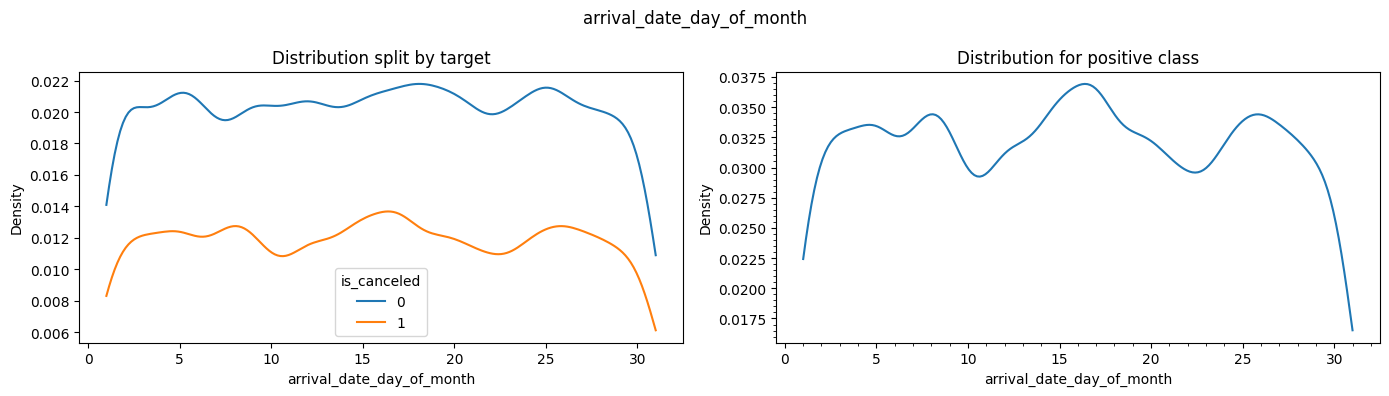

In [114]:
num_dist('arrival_date_day_of_month')

num_dist('arrival_date_day_of_month')**bold text**

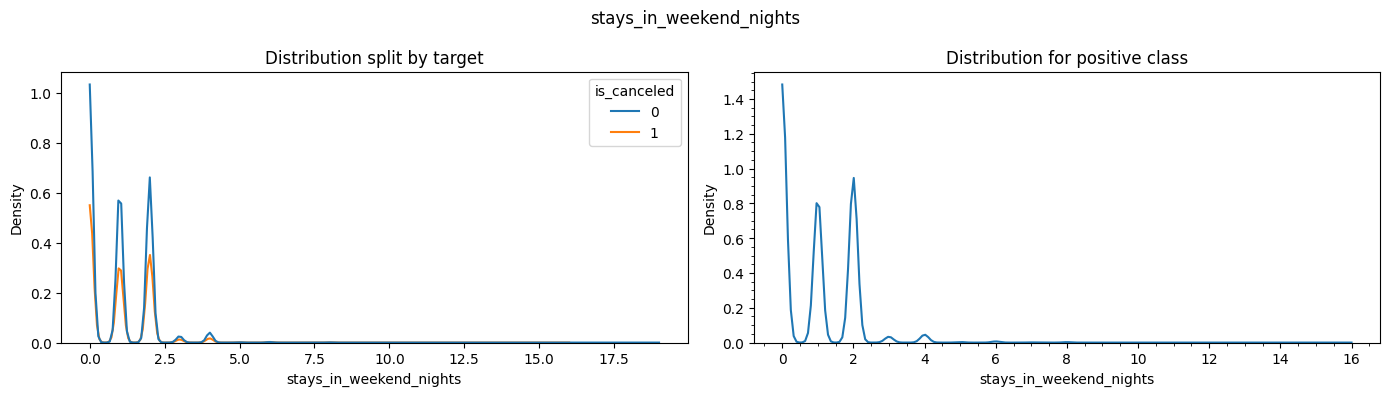

Category proportions:
 only_weekday_stay
0    0.564469
1    0.435531
Name: proportion, dtype: float64

Target splits for each category:
 only_weekday_stay  is_canceled
0                  0              0.633146
                   1              0.366854
1                  0              0.624966
                   1              0.375034
Name: proportion, dtype: float64


In [115]:
num_dist('stays_in_weekend_nights')
data['only_weekday_stay'] = (data['stays_in_weekend_nights'] == 0).astype('int')
cat_dist('only_weekday_stay')

**stays_in_week_nights**

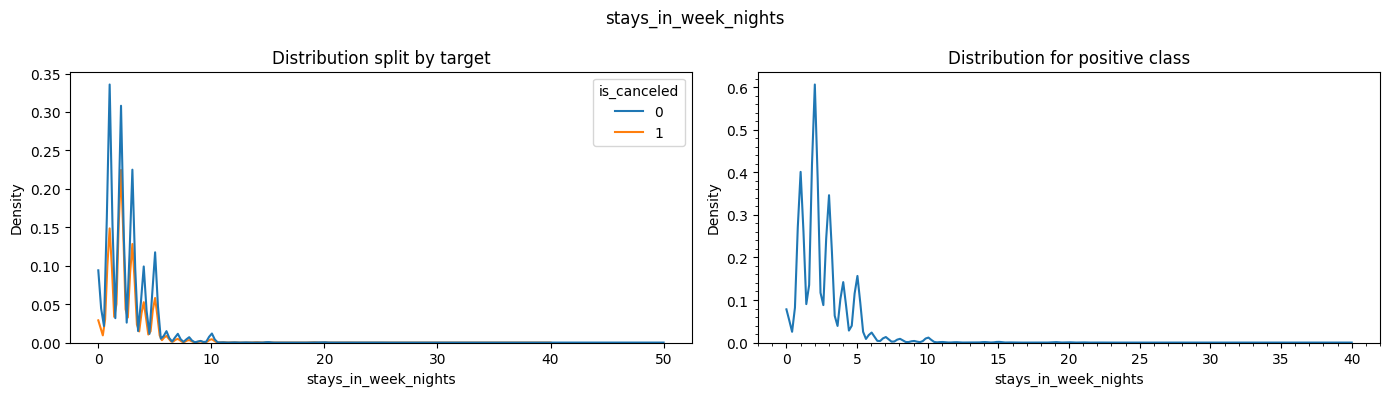

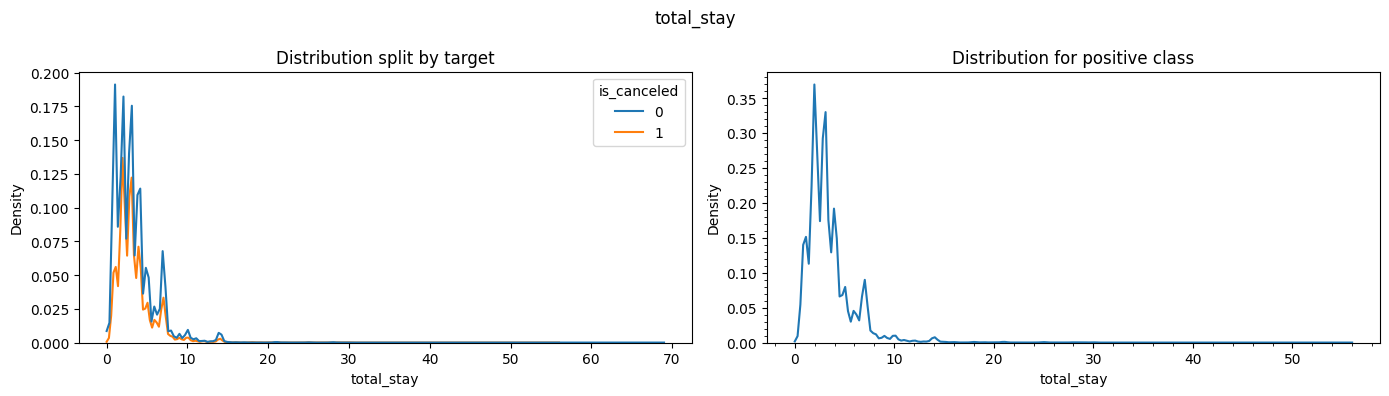

,proportion
total_stay,
2,0.231535
3,0.226786
1,0.176062
4,0.145598
7,0.072494


In [116]:
num_dist('stays_in_week_nights')
data['total_stay'] = data['stays_in_weekend_nights'] + data['stays_in_week_nights']
num_dist('total_stay')
data.total_stay.value_counts(normalize=True).head()

adults, children, **babies**

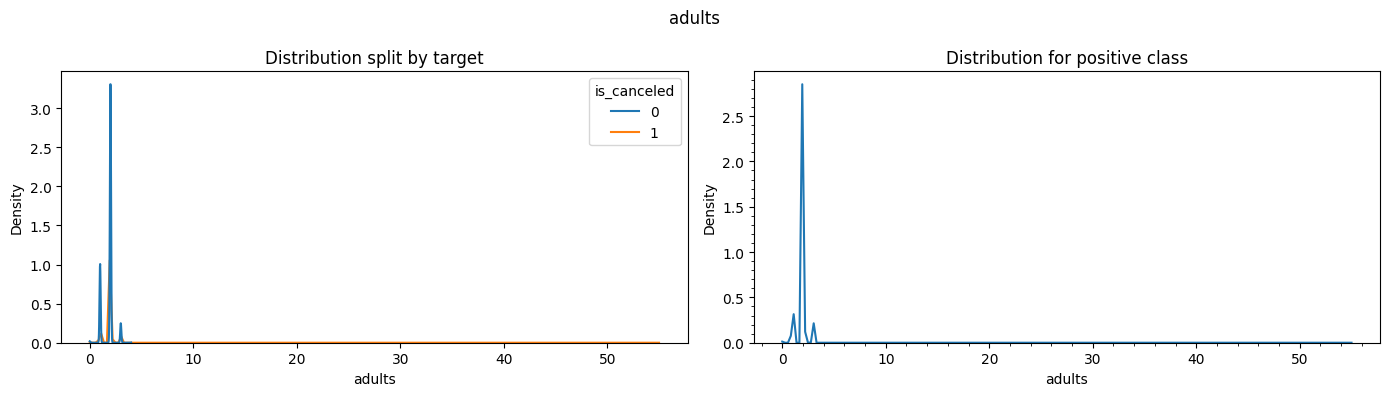

Category proportions:
 adults
2     0.751152
1     0.192872
3     0.051947
0     0.003375
4     0.000519
26    0.000042
27    0.000017
20    0.000017
5     0.000017
40    0.000008
50    0.000008
55    0.000008
6     0.000008
10    0.000008
Name: proportion, dtype: float64

Target splits for each category:
 adults  is_canceled
0       0              0.729529
        1              0.270471
1       0              0.710166
        1              0.289834
2       0              0.606847
        1              0.393153
3       0              0.653176
        1              0.346824
4       0              0.741935
        1              0.258065
5       1              1.000000
6       1              1.000000
10      1              1.000000
20      1              1.000000
26      1              1.000000
27      1              1.000000
40      1              1.000000
50      1              1.000000
55      1              1.000000
Name: proportion, dtype: float64


In [117]:
num_dist('adults')
cat_dist('adults')

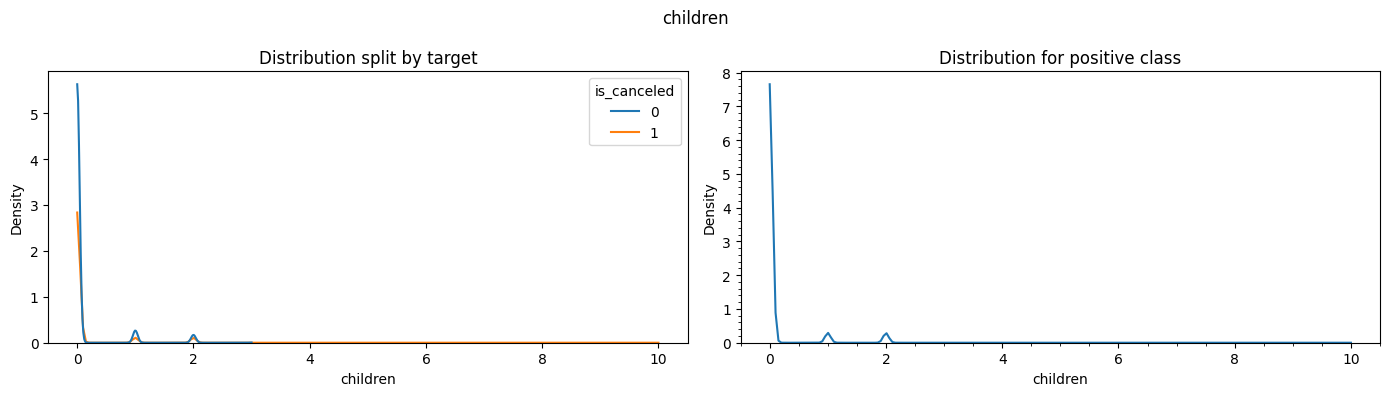

Category proportions:
 children
0.0     0.928017
1.0     0.040715
2.0     0.030589
3.0     0.000637
NaN     0.000034
10.0    0.000008
Name: proportion, dtype: float64

Target splits for each category:
 children  is_canceled
0.0       0              0.629102
          1              0.370898
1.0       0              0.677638
          1              0.322362
2.0       0              0.578039
          1              0.421961
3.0       0              0.776316
          1              0.223684
10.0      1              1.000000
NaN       1              1.000000
Name: proportion, dtype: float64


In [118]:
num_dist('children')
cat_dist('children')

In [119]:
data['have_children'] = (data['children'] > 0).astype('int')
cat_dist('have_children')
cat_dist('babies')

Category proportions:
 have_children
0    0.928051
1    0.071949
Name: proportion, dtype: float64

Target splits for each category:
 have_children  is_canceled
0              0              0.629079
               1              0.370921
1              0              0.636088
               1              0.363912
Name: proportion, dtype: float64
Category proportions:
 babies
0     0.992319
1     0.007538
2     0.000126
10    0.000008
9     0.000008
Name: proportion, dtype: float64

Target splits for each category:
 babies  is_canceled
0       0              0.628126
        1              0.371874
1       0              0.816667
        1              0.183333
2       0              0.866667
        1              0.133333
9       0              1.000000
10      0              1.000000
Name: proportion, dtype: float64


previous_cancellations, **previous_bookings_not_canceled**

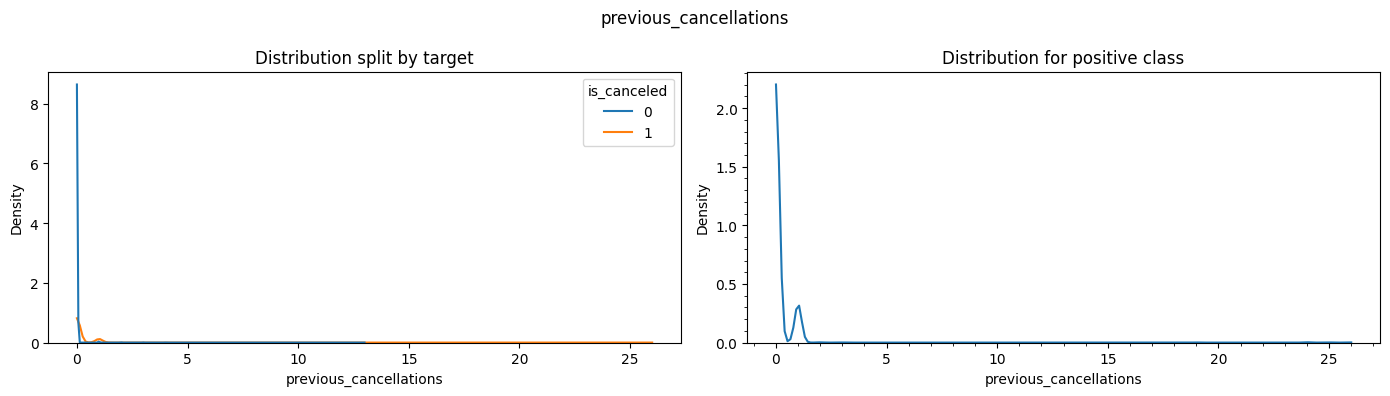

,proportion
previous_cancellations,
0,0.945691
1,0.050683
2,0.000972
3,0.000544
24,0.000402


In [120]:
num_dist('previous_cancellations')
data['previous_cancellations'].value_counts(normalize=True).head()

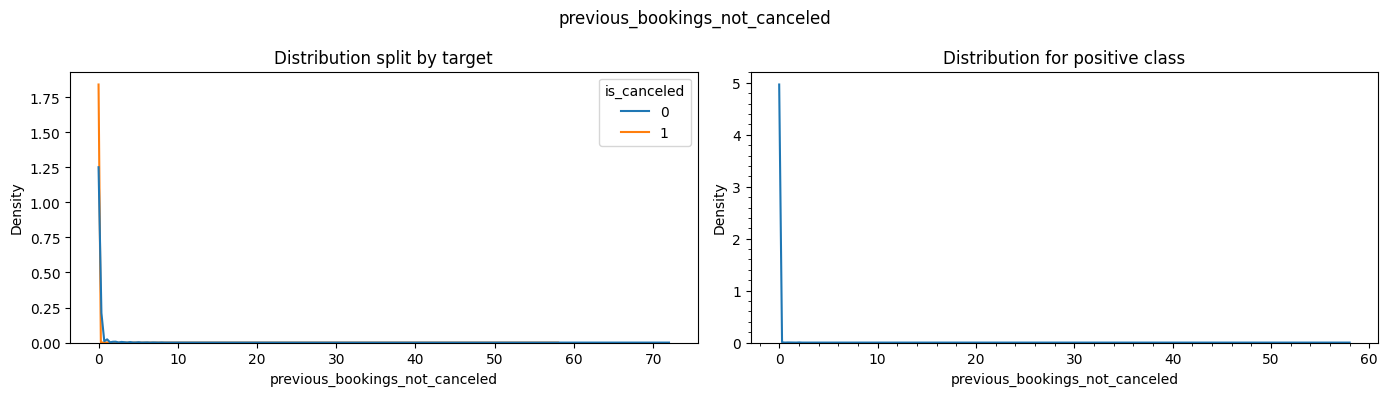

,proportion
previous_bookings_not_canceled,
0,0.969679
1,0.012916
2,0.004858
3,0.002789
4,0.001918


In [121]:
num_dist('previous_bookings_not_canceled')
data['previous_bookings_not_canceled'].value_counts(normalize=True).head()

**days_in_waiting_list**

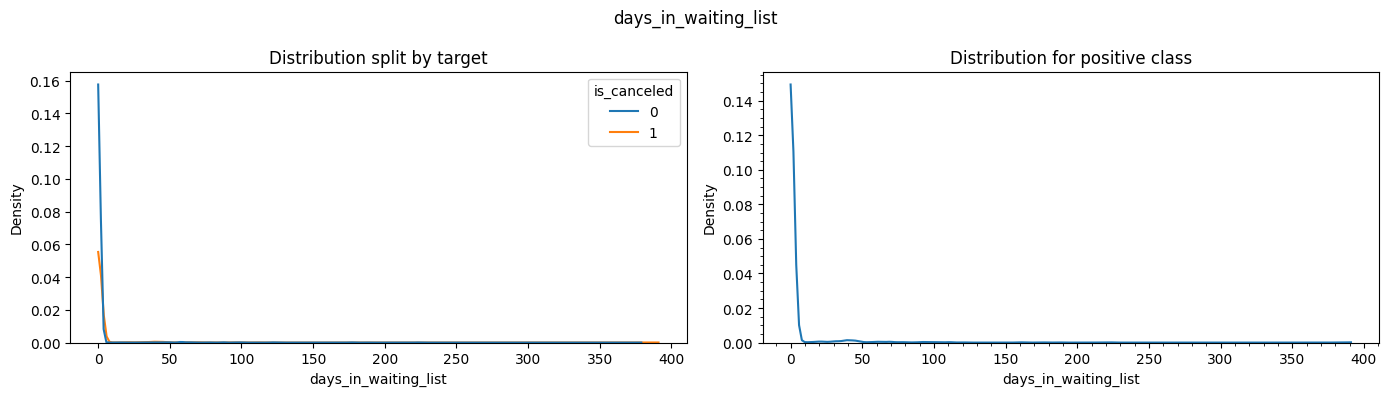

,proportion
days_in_waiting_list,
0,0.969026
39,0.001901
58,0.001374
44,0.001181
31,0.001064


In [122]:
num_dist('days_in_waiting_list')
data['days_in_waiting_list'].value_counts(normalize=True).head()

**adr**

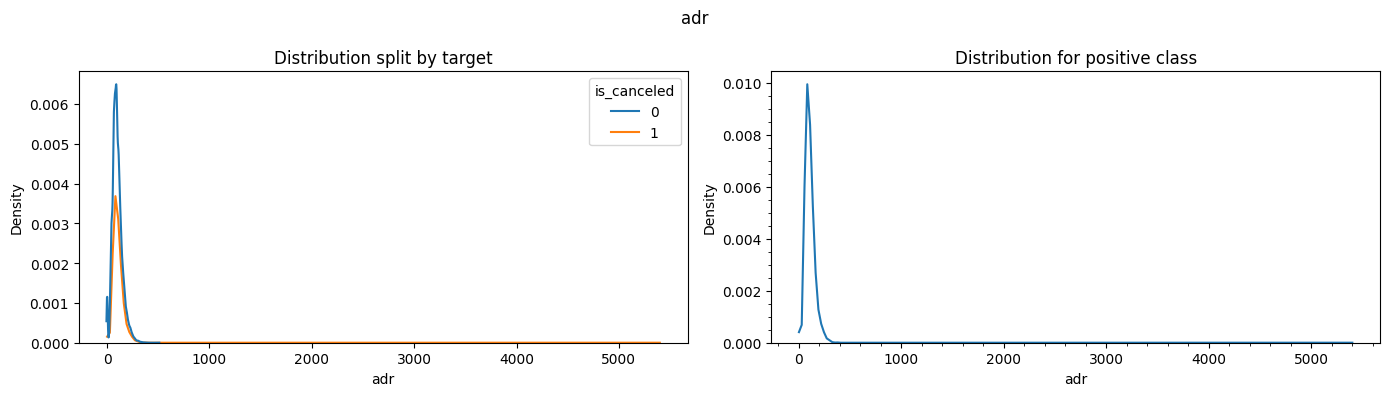

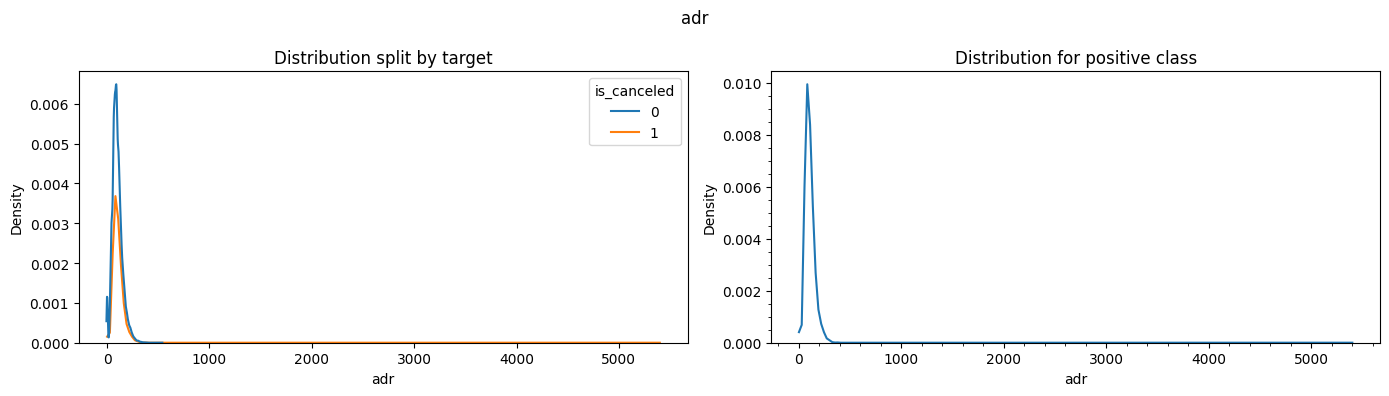

In [123]:
num_dist('adr')
data.loc[38278, 'adr'] = 540
num_dist('adr')

**required_car_parking_spaces**

In [124]:
cat_dist('required_car_parking_spaces')

Category proportions:
 required_car_parking_spaces
0    0.937884
1    0.061839
2    0.000235
3    0.000025
8    0.000017
Name: proportion, dtype: float64

Target splits for each category:
 required_car_parking_spaces  is_canceled
0                            0              0.605051
                             1              0.394949
1                            0              1.000000
2                            0              1.000000
3                            0              1.000000
8                            0              1.000000
Name: proportion, dtype: float64


In [125]:
data['is_parking_required'] = (data['required_car_parking_spaces'] > 0).astype('int')
cat_dist('is_parking_required')

Category proportions:
 is_parking_required
0    0.937884
1    0.062116
Name: proportion, dtype: float64

Target splits for each category:
 is_parking_required  is_canceled
0                    0              0.605051
                     1              0.394949
1                    0              1.000000
Name: proportion, dtype: float64


**total_of_special_requests**

In [126]:
cat_dist('total_of_special_requests')

Category proportions:
 total_of_special_requests
0    0.588977
1    0.278298
2    0.108627
3    0.020915
4    0.002848
5    0.000335
Name: proportion, dtype: float64

Target splits for each category:
 total_of_special_requests  is_canceled
0                          0              0.522796
                           1              0.477204
1                          0              0.779751
                           1              0.220249
2                          0              0.779011
                           1              0.220989
3                          0              0.821386
                           1              0.178614
4                          0              0.894118
                           1              0.105882
5                          0              0.950000
                           1              0.050000
Name: proportion, dtype: float64


# DATA PREPROCESSING

In [127]:
candidate_features = [
    'hotel',  # cat
    'lead_time',  # num
    'arrival_date_year',  # num
    'arrival_date_month',  # num
    'arrival_month_bin',  # cat
    'arrival_date_week_number',  # num
    'arrival_date_day_of_month',  # num
    'total_stay',  # num
    'only_weekday_stay',  # cat
    'adults',  # num
    'have_children',  # cat
    'babies',  # num
    'meal_bin',  # cat
    'country',  # cat - high cardinality
    'market_segment_bin',  # cat
    'distribution_channel_bin',  # cat
    'is_repeated_guest',  # cat
    'previous_cancellations',  # num
    'previous_bookings_not_canceled',  # num
    'same_room_assigned',  # cat
    'agent',  # cat - high cardinality
    'days_in_waiting_list',  # num
    'adr',  # num
    'is_parking_required',  # cat
]

In [128]:
labels = data[TARGET]
data = data[candidate_features]

### Train-Test split

In [129]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels,
    test_size=0.15,
    stratify=labels,
    shuffle=True,
    random_state=SEED
)

### Preprocessing

In [130]:
hotel_mapping = {'Resort Hotel': 0, 'City Hotel': 1}
month_mapping = dict(zip(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July',
     'August', 'September', 'October', 'November', 'December'],
    range(0, 12)
))

In [131]:
train_data['hotel'] = train_data['hotel'].replace(hotel_mapping)
test_data['hotel'] = test_data['hotel'].replace(hotel_mapping)

train_data['arrival_date_month'] = train_data['arrival_date_month'].replace(month_mapping)
test_data['arrival_date_month'] = test_data['arrival_date_month'].replace(month_mapping)


**Target-encoding high-cardinality categorical features**

In [132]:
# Gunakan TargetEncoder untuk transformasi
target_encoder = TargetEncoder(target_type='binary', random_state=SEED)

train_data[['country', 'agent']] = target_encoder.fit_transform(train_data[['country', 'agent']], train_labels)
test_data[['country', 'agent']] = target_encoder.transform(test_data[['country', 'agent']])

# Pastikan kolom data konsisten dengan daftar fitur yang diinginkan
train_data = train_data.reindex(columns=candidate_features, fill_value=0)
test_data = test_data.reindex(columns=candidate_features, fill_value=0)

# Validasi bentuk data
print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")


Train data shape: (101481, 24)
Test data shape: (17909, 24)


# MODEL

In [133]:
def evaluate_on_test_set(model):
    global test_data, test_labels

    probs = model.predict_proba(test_data)[:, 1]
    preds = model.predict(test_data)
    print('\nClassification report:')
    print(classification_report(test_labels, preds, digits=2))

    return probs

## Random Forest

In [134]:
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight='balanced',
    random_state=SEED,
    n_jobs=1
)
rf_model.fit(train_data, train_labels)

rf_probs = evaluate_on_test_set(rf_model)


Classification report:
              precision    recall  f1-score   support

           0       0.93      0.74      0.82     11275
           1       0.67      0.90      0.77      6634

    accuracy                           0.80     17909
   macro avg       0.80      0.82      0.79     17909
weighted avg       0.83      0.80      0.80     17909



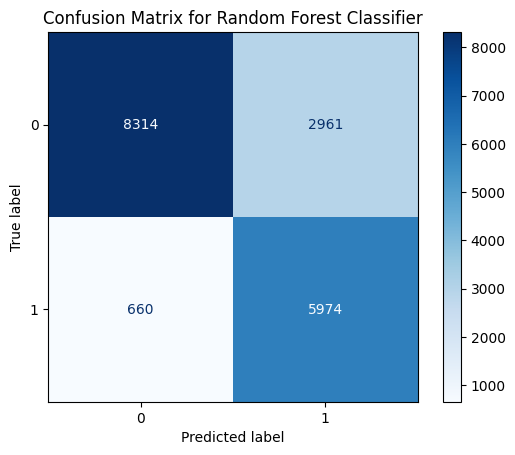

In [135]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prediksi label dari data uji
rf_predictions = rf_model.predict(test_data)

# Hitung confusion matrix
cm = confusion_matrix(test_labels, rf_predictions)

# Visualisasikan confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Random Forest Classifier")
plt.show()


In [136]:
# import joblib
# from google.colab import files

# # Menyimpan model Random Forest
# joblib.dump(rf_model, 'rf_model.pkl')

# files.download('rf_model.pkl')

# # Memuat model Random Forest yang sudah disimpan
# rf_model_loaded = joblib.load('rf_model.pkl')

## FNN

In [137]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Define the FNN model
fnn_model = Sequential([
    Dense(128, activation='relu', input_shape=(train_data.shape[1],)),  # Adjust input shape to your data
    Dropout(0.2),  # Dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(len(set(train_labels)), activation='softmax')  # Output layer with softmax activation
])

# Compile the model
fnn_model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use categorical_crossentropy if labels are one-hot encoded
    metrics=['accuracy']
)

# Train the model
history = fnn_model.fit(
    train_data,
    train_labels,
    epochs=20,  # Adjust based on your dataset
    batch_size=32,
    validation_split=0.2,  # Use part of the training data for validation
    verbose=1
)

# Evaluate the model on the test set
test_loss, test_accuracy = fnn_model.evaluate(test_data, test_labels, verbose=1)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Get probabilities for the test set
fnn_probs = fnn_model.predict(test_data)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2537/2537 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.6270 - loss: 1.5369 - val_accuracy: 0.6606 - val_loss: 0.5979
Epoch 2/20
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 10s 2ms/step - accuracy: 0.6624 - loss: 0.6060 - val_accuracy: 0.6875 - val_loss: 0.5626
Epoch 3/20
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7082 - loss: 0.5511 - val_accuracy: 0.7593 - val_loss: 0.4696
Epoch 4/20
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - accuracy: 0.7525 - loss: 0.4831 - val_accuracy: 0.7844 - val_loss: 0.4286
Epoch 5/20
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - accuracy: 0.7742 - loss: 0.4503 - val_accuracy: 0.7918 - val_loss: 0.4169
Epoch 6/20
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7823 - loss: 0.4330 - val_accuracy: 0.7778 - val_loss: 0.4325
Epoch 7/20
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.7857 - loss: 0.4248 - val_accuracy: 0.7848 - val_loss: 0.4200
Epoch 8/20
2537/2537 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.7866 - loss: 0.4260 - val_accu

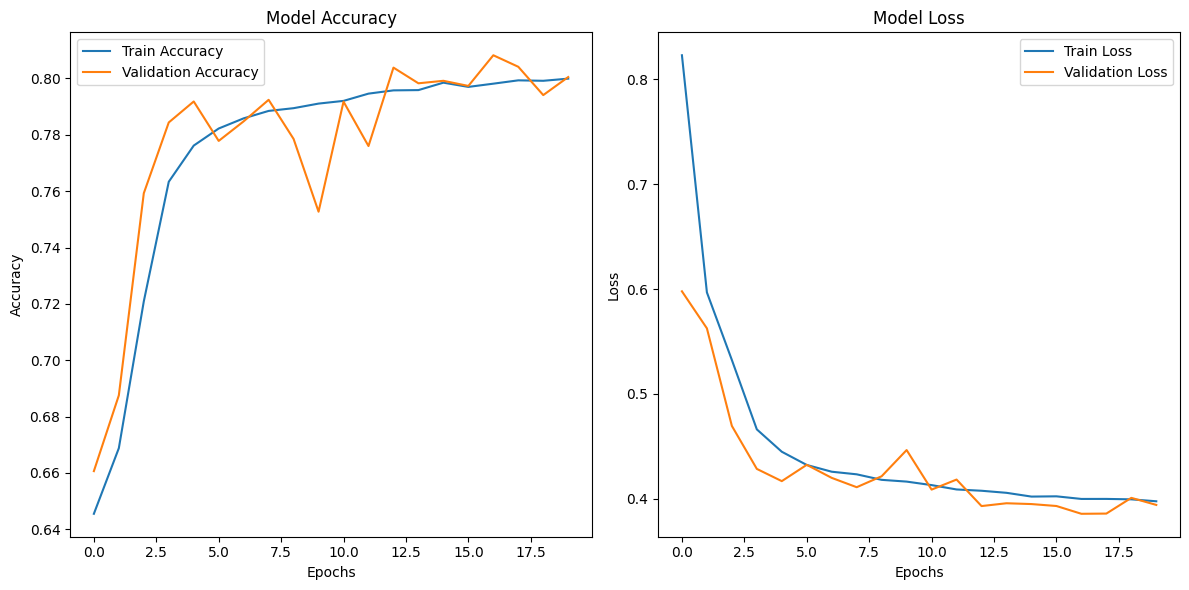

In [138]:
# Accuracy Plot
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()

In [139]:
from sklearn.metrics import classification_report
import numpy as np

# Predict the labels for the test data
test_predictions = fnn_model.predict(test_data)
# Convert the probabilities to class labels (taking the class with the highest probability)
test_pred_labels = np.argmax(test_predictions, axis=1)

# Generate the classification report
report = classification_report(test_labels, test_pred_labels)

# Print the classification report
print(report)


560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.82      0.88      0.85     11275
           1       0.76      0.68      0.72      6634

    accuracy                           0.80     17909
   macro avg       0.79      0.78      0.78     17909
weighted avg       0.80      0.80      0.80     17909



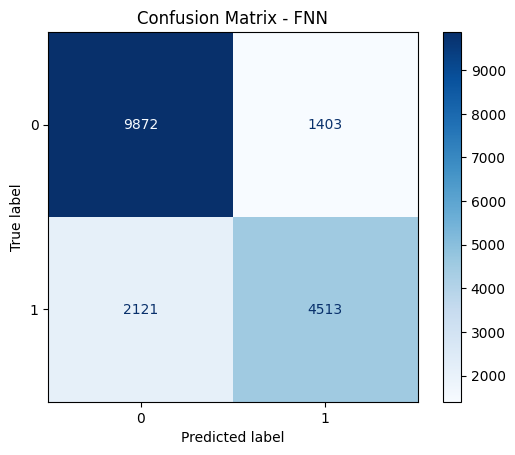

In [142]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Prediksi kelas untuk data uji
fnn_predictions = tf.argmax(fnn_probs, axis=1).numpy()

# Buat confusion matrix
cm = confusion_matrix(test_labels, fnn_predictions)

# Visualisasi confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=set(test_labels))
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - FNN")
plt.show()


In [140]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import files

# Menyimpan model dalam format .keras (format terbaru)
fnn_model.save('my_model.keras')

# Memuat model FNN yang disimpan dengan format .keras
fnn_model_loaded_keras = load_model('my_model.keras')

# Mengunduh model FNN yang disimpan dengan format .keras
files.download('my_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# PERBANDINGAN AKURASI

560/560 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


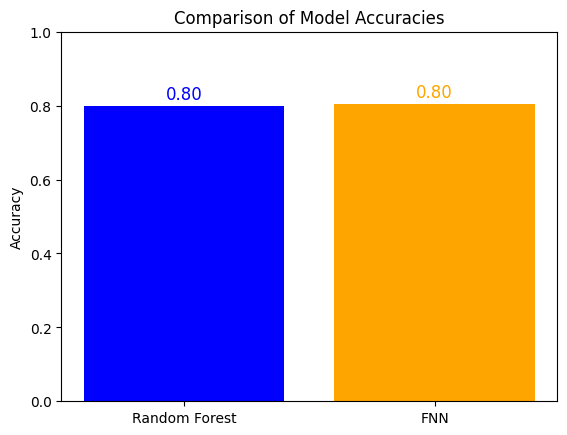

In [141]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Prediksi label untuk data uji
rf_predictions = rf_model.predict(test_data)

# Gunakan model FNN untuk prediksi
fnn_predictions = np.argmax(fnn_model.predict(test_data), axis=1)

# Hitung akurasi untuk kedua model
rf_accuracy = accuracy_score(test_labels, rf_predictions)
fnn_accuracy = accuracy_score(test_labels, fnn_predictions)

# Plot perbandingan akurasi
models = ['Random Forest', 'FNN']
accuracies = [rf_accuracy, fnn_accuracy]

plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylim(0, 1)  # Akurasi berkisar antara 0 dan 1
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.text(0, rf_accuracy + 0.02, f"{rf_accuracy:.2f}", ha='center', color='blue', fontsize=12)
plt.text(1, fnn_accuracy + 0.02, f"{fnn_accuracy:.2f}", ha='center', color='orange', fontsize=12)
plt.show()
